In [1]:
import os
import SimpleITK as sitk
import six
import matplotlib.pyplot as plt
import pydicom
import pydicom.data
import PyQt5
import numpy as np
import os, glob
import pydicom
import pylab as pl
import sys
import matplotlib.path as mplPath
import keyboard
import nibabel as nib
from radiomics import featureextractor 
from radiomics import imageoperations
from collections import OrderedDict
from IPython.core.display import display, HTML
from util import IndexTracker
import nrrd

%matplotlib widget
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Load QSM and segmentation
seg = nib.load('F:/dbs/mclaro/chh/roi/01_roi_combined.nii')
qsm = nib.load('F:/dbs/mclaro/chh/gt/00001_qsm.nii.gz')
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
# Partition mask
seg_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) > 0
rsn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 1
lsn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 2
rrn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 3
lrn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 4
lstn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 5
rstn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 6



Text(0.5, 1.0, 'ROIs and QSM')

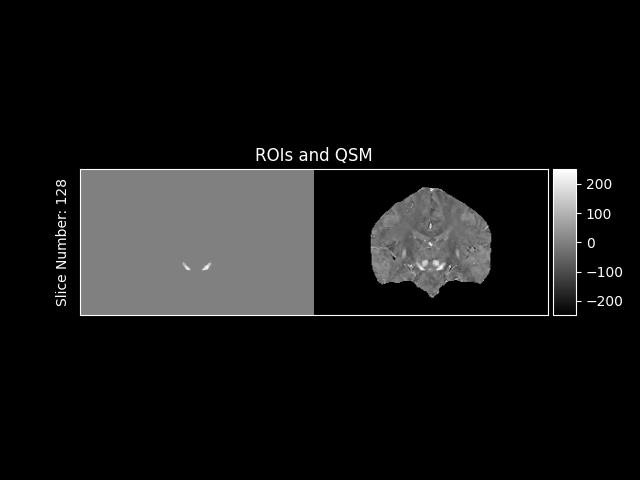

In [5]:
# Combine QSM and mask
y1 = np.hstack((np.rot90(np.swapaxes(np.dstack(qsm.get_fdata()),0,2))*seg_mask,np.rot90(np.swapaxes(np.dstack(qsm.get_fdata()),0,2))))
# Apply window level
y1[y1<m1]=m1
y1[y1>m2]=m2
# Plot
fig1,ax1 = plt.subplots(1,1)
tracker1 = IndexTracker(ax1,y1)
fig1.canvas.mpl_connect('scroll_event', tracker1.onscroll)
ax1.set_title('ROIs and QSM')

In [6]:
# Convert to SITK images
roi_masks = [rsn_mask,lsn_mask,rrn_mask,lrn_mask,lstn_mask,rstn_mask]
qsm_np = np.rot90(np.swapaxes(np.dstack(qsm.get_fdata()),0,2))
qsm_sitk = sitk.GetImageFromArray(qsm_np) 
for i in range(len(roi_masks)):
    seg_sitk = sitk.GetImageFromArray(np.float64(roi_masks[i]))
# Extract 1st order features
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
print('Enabled features:\n\t', extractor.enabledFeatures)
features1 = OrderedDict()
featureVector1 = extractor.execute(qsm_sitk,seg_sitk,voxelBased=True)
result1 = features1
Finalresult=six.iteritems(result1)

for key, value in six.iteritems(featureVector1):
    if isinstance(value, sitk.Image):
        sitk.WriteImage(value, key + '.nrrd',True)
        sitk.WriteImage(seg_sitk, 'seg' + '.nrrd',True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))        
    else:  # Diagnostic information
        print("\t%s: %s" %(key, value))
        if key == 'diagnostics_Mask-original_BoundingBox':
            lims = value
            # Assuming kernel radius of 3, slide of 1, and padding of 0
            sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop' + '.nrrd',True)
            sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop' + '.nrrd',True)
        

Enabled features:
	 {'firstorder': []}
	diagnostics_Versions_PyRadiomics: v3.0.1
	diagnostics_Versions_Numpy: 1.21.5
	diagnostics_Versions_SimpleITK: 2.2.1
	diagnostics_Versions_PyWavelet: 1.3.0
	diagnostics_Versions_Python: 3.7.15
	diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'voxelBased': True}
	diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
	diagnostics_Image-original_Hash: 00d423419f4046d629f66deadd8cfcd53dbd3aea
	diagnostics_Image-original_Dimensionality: 3D
	diagnostics_Image-original_Spacing: (1.0, 1.0, 1.0)
	diagnostics_Image-original_Size: (256, 256, 160)
	diagnostics_Image-original_Mean: -28427.60092716217
	diagnostics_Image-original_Minimum:

In [7]:
qsm_crop_sitk = qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1]
seg_data, seg_header = nrrd.read('qsm_crop.nrrd')
grad_sitk = sitk.Gradient(qsm_crop_sitk)
sitk.WriteImage(grad_sitk, 'grad' + '.nrrd',True)

grad_data, grad_header = nrrd.read('grad.nrrd')
mean, mean_header = nrrd.read('original_firstorder_Mean.nrrd')
median, median_header = nrrd.read('original_firstorder_Median.nrrd')
variance, variance_header = nrrd.read('original_firstorder_Variance.nrrd')
skewness, skewness_header = nrrd.read('original_firstorder_Skewness.nrrd')
kurtosis, kurtosis_header = nrrd.read('original_firstorder_Kurtosis.nrrd')
energy, energy_header = nrrd.read('original_firstorder_Energy.nrrd')
entropy, entropy_header = nrrd.read('original_firstorder_Entropy.nrrd')


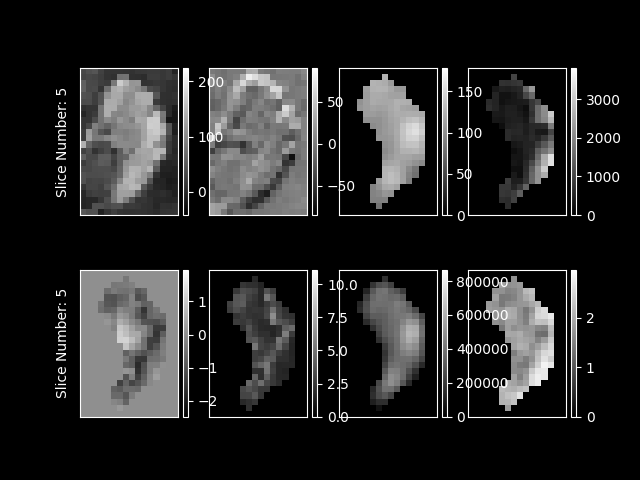

In [8]:
fig2, ax2 = plt.subplots(2,4)
y2 = seg_data
tracker3 = IndexTracker(ax2[0,0], y2)
tracker4 = IndexTracker(ax2[0,1], grad_data[0].astype('float'), 'hide labels')
tracker5 = IndexTracker(ax2[0,2], mean, 'hide labels')
tracker6 = IndexTracker(ax2[0,3], variance, 'hide labels')
tracker7 = IndexTracker(ax2[1,0], skewness)
tracker8 = IndexTracker(ax2[1,1], kurtosis, 'hide labels')
tracker9 = IndexTracker(ax2[1,2], energy, 'hide labels')
tracker10 = IndexTracker(ax2[1,3], entropy, 'hide labels')
fig2.canvas.mpl_connect('scroll_event', tracker3.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker4.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker5.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker6.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker7.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker8.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker9.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker10.onscroll)
plt.show()
plt.set_cmap('gray')
ax2[0,0].set_xlabel('QSM')
ax2[0,1].set_xlabel('Gradient')
ax2[0,2].set_xlabel('Mean')
ax2[0,3].set_xlabel('Variance')
ax2[1,0].set_xlabel('Skewness')
ax2[1,1].set_xlabel('Kurtosis')
ax2[1,2].set_xlabel('Energy')
ax2[1,3].set_xlabel('Entropy')
plt.style.use('dark_background')
fig2.suptitle('Some histogram feature maps of healthy right subthalmic nucleus');

In [9]:
# Extract some Gray Level Co-occurence Matrix (GLCM) features
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeaturesByName(glcm=['Contrast', 'JointEnergy','JointEntropy'])
print('Enabled features:\n\t', extractor.enabledFeatures)
featureVector2 = extractor.execute(qsm_sitk,seg_sitk,voxelBased=True)


Enabled features:
	 {'glcm': ['Contrast', 'JointEnergy', 'JointEntropy']}


In [10]:
features2 = OrderedDict()
result2 = features2
Finalresult2=six.iteritems(result2)
for key, value in six.iteritems(featureVector2):
    if isinstance(value, sitk.Image):
        sitk.WriteImage(value, key + '.nrrd',True)
        sitk.WriteImage(seg_sitk, 'seg' + '.nrrd',True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))        
    else:  # Diagnostic information
        print("\t%s: %s" %(key, value))
        if key == 'diagnostics_Mask-original_BoundingBox':
            lims = value
            # Assuming kernel radius of 3, slide of 1, and padding of 0
            sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop' + '.nrrd',True)
            sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop' + '.nrrd',True)

	diagnostics_Versions_PyRadiomics: v3.0.1
	diagnostics_Versions_Numpy: 1.21.5
	diagnostics_Versions_SimpleITK: 2.2.1
	diagnostics_Versions_PyWavelet: 1.3.0
	diagnostics_Versions_Python: 3.7.15
	diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'voxelBased': True}
	diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
	diagnostics_Image-original_Hash: 00d423419f4046d629f66deadd8cfcd53dbd3aea
	diagnostics_Image-original_Dimensionality: 3D
	diagnostics_Image-original_Spacing: (1.0, 1.0, 1.0)
	diagnostics_Image-original_Size: (256, 256, 160)
	diagnostics_Image-original_Mean: -28427.60092716217
	diagnostics_Image-original_Minimum: -32768.0
	diagnostics_Image-original_M

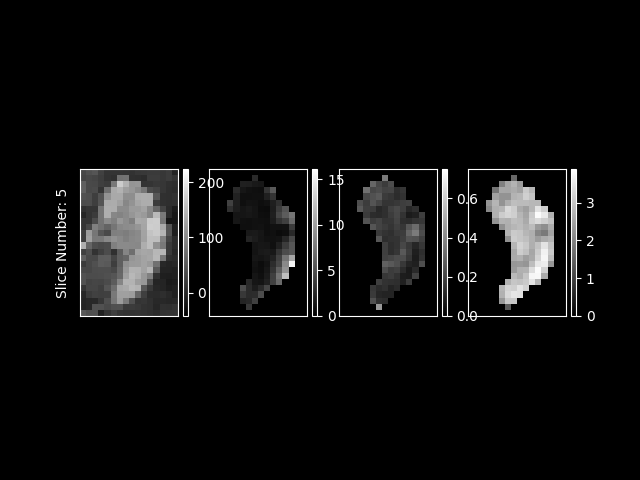

In [11]:
contrast, contrast_header = nrrd.read('original_glcm_Contrast.nrrd')
joint_energy, joint_energy_header = nrrd.read('original_glcm_JointEnergy.nrrd')
joint_entropy, joint_entropy_header = nrrd.read('original_glcm_JointEntropy.nrrd')

fig3, ax3 = plt.subplots(1,4)
y3 = seg_data
tracker11 = IndexTracker(ax3[0], y3)
tracker12 = IndexTracker(ax3[1], contrast, 'hide labels')
tracker13 = IndexTracker(ax3[2], joint_energy, 'hide labels')
tracker14 = IndexTracker(ax3[3], joint_entropy, 'hide labels')

fig3.canvas.mpl_connect('scroll_event', tracker11.onscroll)
fig3.canvas.mpl_connect('scroll_event', tracker12.onscroll)
fig3.canvas.mpl_connect('scroll_event', tracker13.onscroll)
fig3.canvas.mpl_connect('scroll_event', tracker14.onscroll)

plt.show()
plt.set_cmap('gray')
ax3[0].set_xlabel('QSM')
ax3[1].set_xlabel('Contrast')
ax3[2].set_xlabel('Joint Energy')
ax3[3].set_xlabel('Joint Entropy')

plt.style.use('dark_background')
fig3.suptitle('Some gray level co-occurence matrix feature maps of healthy right subthalmic nucleus');

In [12]:
# Extract some Gray Level Run Length Matrix (GLRLM) features
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeaturesByName(glrlm=['RunPercentage','ShortRunEmphasis','LongRunEmphasis','RunLengthNonUniformity'])
print('Enabled features:\n\t', extractor.enabledFeatures)
featureVector3 = extractor.execute(qsm_sitk,seg_sitk,voxelBased=True)

Enabled features:
	 {'glrlm': ['RunPercentage', 'ShortRunEmphasis', 'LongRunEmphasis', 'RunLengthNonUniformity']}


In [13]:
features3 = OrderedDict()
result3 = features3
Finalresult3=six.iteritems(result3)
for key, value in six.iteritems(featureVector3):
    if isinstance(value, sitk.Image):
        sitk.WriteImage(value, key + '.nrrd',True)
        sitk.WriteImage(seg_sitk, 'seg' + '.nrrd',True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))        
    else:  # Diagnostic information
        print("\t%s: %s" %(key, value))
        if key == 'diagnostics_Mask-original_BoundingBox':
            lims = value
            # Assuming kernel radius of 3, slide of 1, and padding of 0
            sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop' + '.nrrd',True)
            sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop' + '.nrrd',True)

	diagnostics_Versions_PyRadiomics: v3.0.1
	diagnostics_Versions_Numpy: 1.21.5
	diagnostics_Versions_SimpleITK: 2.2.1
	diagnostics_Versions_PyWavelet: 1.3.0
	diagnostics_Versions_Python: 3.7.15
	diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'voxelBased': True}
	diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
	diagnostics_Image-original_Hash: 00d423419f4046d629f66deadd8cfcd53dbd3aea
	diagnostics_Image-original_Dimensionality: 3D
	diagnostics_Image-original_Spacing: (1.0, 1.0, 1.0)
	diagnostics_Image-original_Size: (256, 256, 160)
	diagnostics_Image-original_Mean: -28427.60092716217
	diagnostics_Image-original_Minimum: -32768.0
	diagnostics_Image-original_M

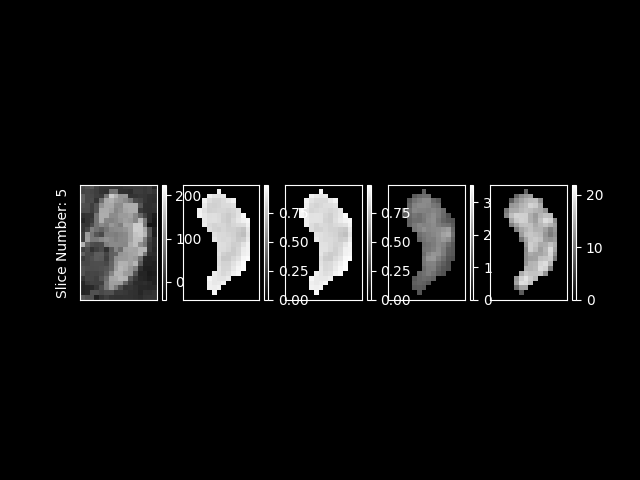

In [14]:
run_percentage, run_percentage_header = nrrd.read('original_glrlm_RunPercentage.nrrd')
short_run_emphasis, short_run_emphasis_header = nrrd.read('original_glrlm_ShortRunEmphasis.nrrd')
long_run_emphasis, long_run_emphasis_header = nrrd.read('original_glrlm_LongRunEmphasis.nrrd')
run_length_nonuniformity, run_length_nonuniformity_header = nrrd.read('original_glrlm_RunLengthNonUniformity.nrrd')


fig4, ax4 = plt.subplots(1,5)
y4 = seg_data
tracker15 = IndexTracker(ax4[0], y4)
tracker16 = IndexTracker(ax4[1], run_percentage, 'hide labels')
tracker17 = IndexTracker(ax4[2], short_run_emphasis, 'hide labels')
tracker18 = IndexTracker(ax4[3], long_run_emphasis, 'hide labels')
tracker19 = IndexTracker(ax4[4], run_length_nonuniformity, 'hide labels')

fig4.canvas.mpl_connect('scroll_event', tracker15.onscroll)
fig4.canvas.mpl_connect('scroll_event', tracker16.onscroll)
fig4.canvas.mpl_connect('scroll_event', tracker17.onscroll)
fig4.canvas.mpl_connect('scroll_event', tracker18.onscroll)
fig4.canvas.mpl_connect('scroll_event', tracker19.onscroll)

plt.show()
plt.set_cmap('gray')
ax4[0].set_xlabel('QSM')
ax4[1].set_xlabel('Run Percentage')
ax4[2].set_xlabel('Short Run Emphasis')
ax4[3].set_xlabel('Long Run Emphasis')
ax4[4].set_xlabel('Run Length Nonuniformity')

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 5000
fig4.suptitle('Some gray level run-length matrix feature maps of healthy right subthalmic nucleus');